In [5]:
__file__ = 'scrap_notebook'
import cv2
import numpy as np
import os
import torch
import torch.distributed

import vis_utils
from detectron2.evaluation.evaluator import inference_context
from detectron2.utils.events import EventStorage
from script_utils import FigExporter, get_custom_maskrcnn_cfg, run_batch_results_visualization, get_datapoint_file, \
    convert_datapoint_to_image_format
from trainer_apd import Trainer_APD

def visualize_groundtruth(cfg, datapoint, exporter, image_id):
    vis_utils.show_groundtruth(datapoint, cfg)
    exporter.export_gcf(os.path.splitext(os.path.basename(__file__))[0] + '_' + image_id + '_groundtruth')

exporter_ = None

image_id='486536'
custom_head=False
max_iters=1
exporter=None
exporter = exporter or FigExporter()
cfg = get_custom_maskrcnn_cfg()
trainer = Trainer_APD(cfg)
datapoint = torch.load(get_datapoint_file(cfg, image_id))

if type(datapoint) is list:
    datapoint = datapoint[0]

visualize_groundtruth(cfg, datapoint, exporter, image_id)

Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x_APD.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Exported /home/adelgior/workspace/images/000001_scrap_notebook_486536_groundtruth.png


In [6]:
def prep_image(datapoint, cfg):
    image_filename = datapoint['file_name']
    input_image = datapoint['image']
    input_image = np.asarray(input_image.permute(1, 2, 0)[:, :, [2, 1, 0]])
    input_image_from_file = cv2.imread(image_filename)
    input_image = convert_datapoint_to_image_format(input_image, input_image_from_file.shape[:2], cfg)
    return input_image

input_image = prep_image(datapoint, cfg)
trainer_type = 'custom' if custom_head else 'standard'
trainer.model.roi_heads.active_mask_head = trainer_type
cfg_tag = f"_{trainer_type}"
n_existing_exporter_images = len(exporter.generated_figures)
batch = [datapoint]

In [7]:
# Pre-training inference
def visualize_results(batch, cfg, cfg_tag, exporter, image_id, input_image, n_existing_exporter_images, outputs_d,
                      posttrain_tag, trainer):
    # create artificial output_d's so that each proposal is visualized one at a time.
    run_batch_results_visualization([input_image], cfg, outputs_d,
                                    image_ids=[str(d['image_id']) + cfg_tag + posttrain_tag for d in batch],
                                    model=trainer.model, exporter=exporter)
    figure_name = os.path.splitext(os.path.basename(__file__))[0] + '_' + image_id + cfg_tag + \
                  posttrain_tag + '_collated'
    vis_utils.collate_figures(exporter.generated_figures[n_existing_exporter_images:], figure_name,
                              exporter=exporter)
    return os.path.join(exporter.workspace_dir, figure_name + '.png')

def run_inference(trainer, inputs):
    previously_training = trainer.model.training
    trainer.model.eval()
    with inference_context(trainer.model), torch.no_grad():
        # Get proposals
        images = trainer.model.preprocess_image(inputs)
        features = trainer.model.backbone(images.tensor)
        proposalss, proposal_lossess = trainer.model.proposal_generator(images, features, None)

        # Get instance boxes, masks, and proposal idxs
        outputs, extra_proposal_details = trainer.model(inputs, trace_proposals=True)

    if previously_training:
        trainer.model.train()

    return {'outputs': outputs,
            'proposalss': proposalss,
            'proposal_lossess': proposal_lossess,
            'extra_proposal_details': extra_proposal_details
            }

outputs_d = run_inference(trainer, batch)


Exported /home/adelgior/workspace/images/000047_vis_utils_486536_standard_pretrain_proposals.png
Exported /home/adelgior/workspace/images/000048_vis_utils_486536_standard_pretrain_proposals_past_thresh.png
Exported /home/adelgior/workspace/images/000049_vis_utils_486536_standard_pretrain_selected_proposals.png
Exported /home/adelgior/workspace/images/000050_vis_utils_486536_standard_pretrain_prediction.png


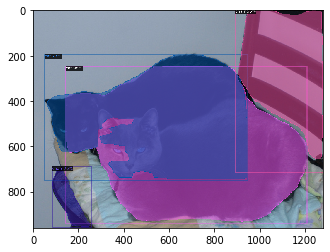

In [21]:
posttrain_tag = '_pretrain'
run_batch_results_visualization([input_image], cfg, outputs_d,
                                image_ids=[str(d['image_id']) + cfg_tag + posttrain_tag for d in batch],
                                model=trainer.model, exporter=exporter)

In [39]:
from script_utils import dictoflists_to_listofdicts
proposal_details = dictoflists_to_listofdicts(outputs_d['extra_proposal_details'])
proposals_batch = outputs_d['proposalss']

for proposals, proposal_details, img in zip(proposals_batch, proposal_details, [input_image]):
    print(len(proposals))
    print(proposal_details['selected_proposal_idxs'])
    print(proposals[proposal_details['selected_proposal_idxs']])

1000
tensor([ 1, 76, 61, 25], device='cuda:0')
Instances(num_instances=4, image_height=672, image_width=896, fields=[proposal_boxes, objectness_logits])


In [54]:
outputs_d['outputs'][0]['instances']._fields.keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes', 'pred_masks'])

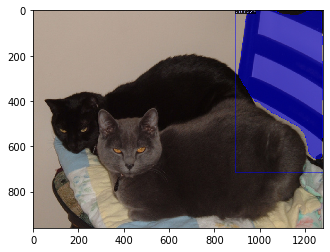

In [73]:
from vis_utils import show_prediction
from detectron2.data import MetadataCatalog


for proposals, proposal_details, outputs, img in zip(proposals_batch, proposal_details, outputs_d['outputs'], [input_image]):
    n_instances = len(outputs['instances'])
    dir(outputs['instances'])
    for i in range(n_instances):
        instance = outputs['instances'][[i]]
        show_prediction(img, {'instances': instance}, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
        